<a href="https://colab.research.google.com/github/thnkang/W266_Sp2022_Final_Project/blob/main/w281_fp_integrated_rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W-281 Final Project

#Introduction
<p> The goal of our project is to use computer vision algorithms that interprets American sign language (ASL) gestures with high accuracy. The National Institute on Deafness and other Communications Disorders (NIDCD) indicates that the 200-year-old American Sign Language is a complete, complex language (of which letter gestures are only part) but is the primary language for many deaf North Americans. ASL is the leading minority language in the U.S. after the "big four": Spanish, Italian, German, and French. An application of our project could be to build a Text-to-Speech software that enables improved and automated translation of ASL gestures.

We first import all the necessarily libraries in python.

In [60]:
import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import cv2

from skimage.feature import hog
from skimage import data, exposure

from scipy import fftpack

import time
from sklearn.manifold import *
from sklearn.metrics import accuracy_score
from sklearn.decomposition import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
seed = 1234
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.utils import np_utils
from keras import layers
from keras import *
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dense, GaussianNoise, Dropout

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/MyDrive/archive.zip

Archive:  gdrive/MyDrive/archive.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


The image below shows the different hand gestures used for representing letters in ASL. 

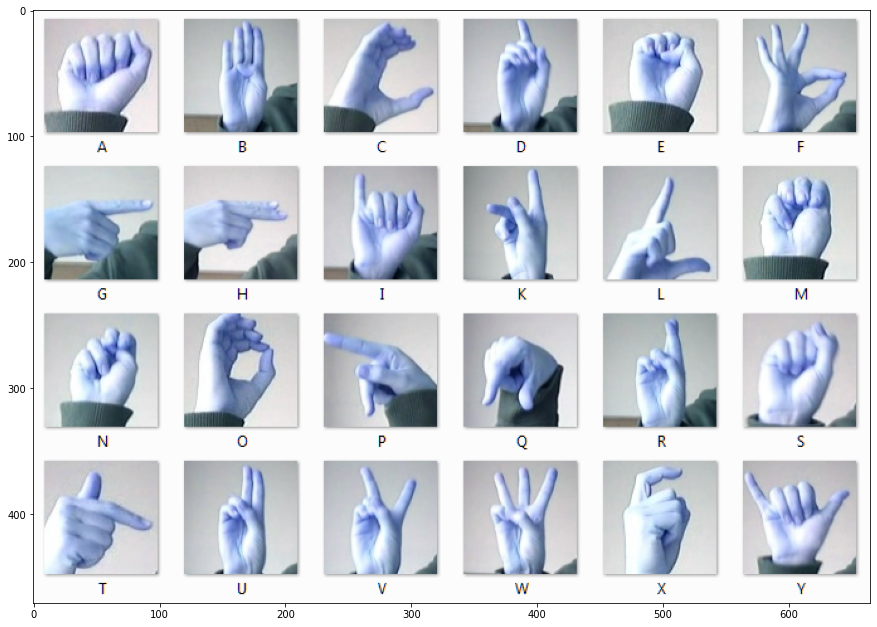

In [ ]:
#@title
img_path = ["american_sign_language.PNG",
            "amer_sign3.png",
            "amer_sign2.png"]
img = cv2.imread(img_path[2], cv2.IMREAD_COLOR)
plt.figure(figsize=(15,15))
plt.imshow(img)

# Data Set
The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications.

As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel".

The Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. It is a database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

# Pixel features: Exploratory Data Analysis
We first take a look at 10 example images from the dataset. We also see that the distribution of images according to each label is uniform without any class being over or under-represented. In addition, there are no missing pixel values in the train or test data-set.

In [94]:
# Load data
df_train = pd.read_csv("gdrive/MyDrive/w281/sign_mnist_train/sign_mnist_train.csv")
df_test = pd.read_csv("gdrive/MyDrive/w281/sign_mnist_test/sign_mnist_test.csv")
df_train.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  pixel10  pixel11  pixel12  pixel13  pixel14  pixel15  pixel16  \
0     153      156      158      160      163      165      159      166   
1     158      157      158      156      154      154      153      152   
2     187      186      185      185      185      184      184      184   
3     210      211      209      207      208      207      206      203   
4     185      186      188      189      189      190      191      189   

   pixel17  pixel18  pixel19  pixel20  pixel21  pixel22  pixel23  pixel24  \
0      168      170      170      171      171      171      172      171   
1      151      149      149      148      147      146      144      142   
2      181      181      179      179      179      178      178      109   
3      202      201      200      198      197      195      192      197   
4      190      190      187      190      192      193      191      191   

   pixel25  pixel26  pixel27  pixel28  pixel29  pixel30  pixel31  pixel32  \
0      171      170      170      169      111      121      129      135   
1      143      138       92      108      158      159      159      159   
2       52       66       77       83      188      189      189      188   
3      171       51       52       54      212      213      215      215   
4      192      192      194      194      166      169      172      174   

   pixel33  pixel34  pixel35  pixel36  pixel37  pixel38  pixel39  pixel40  \
0      141      144      148      151      154      157      160      163   
1      160      160      160      160      160      160      160      159   
2      188      189      188      188      188      188      187      185   
3      212      212      213      212      212      211      211      209   
4      177      180      182      185      186      187      190      191   

   pixel41  pixel42  pixel43  pixel44  pixel45  pixel46  pixel47  pixel48  \
0      164      170      119      152      171      171      170      171   
1      158      157      155      154      153      152      151      150   
2      185      187      182      177      182      182      182      180   
3      208      209      206      204      203      202      201      200   
4      190      191      192      192      194      182      152      146   

   pixel49  pixel50  pixel51  pixel52  pixel53  pixel54  pixel55  pixel56  \
0      172      172      172      172      172      171      171      170   
1      149      149      147      147      146      142      116      143   
2      180      179      180      135       67       73       73       71   
3      199      197      193      204      149       44       49       46   
4      189      195      194      193      193      194      195      195   

   pixel57  pixel58  pixel59  pixel60  pixel61  pixel62  pixel63  pixel64  \
0      113      123      131      137      142      145      150      152   
1      161      161      161      161      162      161      162      162   
2      190      190      190      191      190      190      189      189   
3      215      217      218      217      216      216      217      214   
4      167      170      173      176      178      181      183      186   

   pixel65  pixel66  pixel67  pixel68  pixel69  pixel70  pixel71  pixel72  \
0      155      158      161      163      164      172      105      142   
1      162      162      161      161      161      160      159      158   
2      189      188      189      188      192      184      144      103   
3  

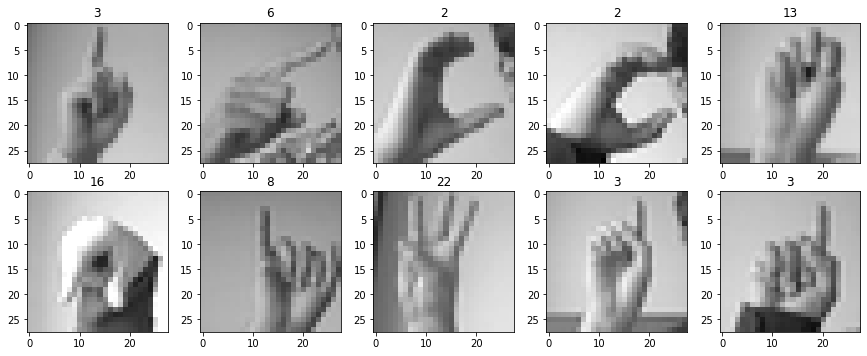

In [15]:
# Examples of images
plt.figure(figsize=(15,15))
for i in range(10):
    img = np.array(df_train.iloc[i, 1:].values).reshape(28,28)

    plt.subplot(5,5, i+1)
    plt.imshow(img,cmap='gray', vmin=0, vmax=255)
    plt.title(df_train.iloc[i, 0])

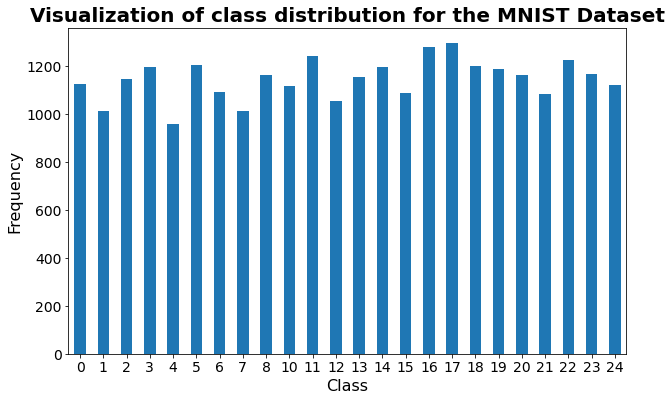

In [16]:
df_train['label'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Visualization of class distribution for the MNIST Dataset', fontsize=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Frequency', fontsize=16);

### Splitting the data into training and validation sets

In [95]:
# Get all pixel features
features = [col for col in df_train.columns if col.startswith('pixel')]
# Split up training to for validation
X_train, X_val, y_train, y_val = train_test_split(df_train[features], 
                                                  df_train['label'], 
                                                  test_size=0.25, 
                                                  random_state=seed)

In [96]:
X_test = df_test[features].values
y_test = df_test['label'].values

In [97]:
X_train.shape, y_train.shape

((20591, 784), (20591,))

In [98]:
X_test.shape, y_test.shape

((7172, 784), (7172,))

In [99]:
#Changing y to categorical variables
y_train = y_train.astype('int32')
Y_train = np_utils.to_categorical(y_train) 
y_val = y_val.astype('int32')
Y_val = np_utils.to_categorical(y_val)
y_test = y_test.astype('int32')
Y_test = np_utils.to_categorical(y_test)

In [100]:
Y_train.shape, Y_val.shape, Y_test.shape

((20591, 25), (6864, 25), (7172, 25))

### t-SNE

t-SNE (t-distributed stochastic neighbor embedding) is a dimensionality reduction algorithm which is popularly used to reduce the dimensionality in samples. If we have data where samples are characterized by n features, t-SNE generates a lower number of features (typically two) that also preserves the relationship between samples. 
<p> In this project, we also reduce the 784 pixel features to 2 and take a look at the resulting clusters. 

In [101]:
model = TSNE(n_components = 2, random_state =0, perplexity =50, n_iter=1000, verbose = 1)
X_tsne_train = model.fit_transform(X_train/255)

print('shape of tsne_reduced.shape = ', X_tsne_train.shape)

tsne_data = np.vstack((X_tsne_train.T, y_train)).T
tsne_df = pd.DataFrame(tsne_data, columns = ('Col 1', 'Col 2', 'label'))
tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20591 samples in 0.011s...
[t-SNE] Computed neighbors for 20591 samples in 12.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20591
[t-SNE] Computed conditional probabilities for sample 2000 / 20591
[t-SNE] Computed conditional probabilities for sample 3000 / 20591
[t-SNE] Computed conditional probabilities for sample 4000 / 20591
[t-SNE] Computed conditional probabilities for sample 5000 / 20591
[t-SNE] Computed conditional probabilities for sample 6000 / 20591
[t-SNE] Computed conditional probabilities for sample 7000 / 20591
[t-SNE] Computed conditional probabilities for sample 8000 / 20591
[t-SNE] Computed conditional probabilities for sample 9000 / 20591
[t-SNE] Computed conditional probabilities for sample 10000 / 20591
[t-SNE] Computed conditional probabilities for sample 11000 / 20591
[t-SNE] Computed conditional probabilities for sample 12000 / 20591
[t-SNE] Computed conditional probabilities for s

Col 1      Col 2  label
0 -62.575077  55.248009   21.0
1  -8.970036  -6.531845   17.0
2 -35.113033  73.841042   15.0
3  39.860245 -59.228161   13.0
4  -5.425441 -40.465015    4.0

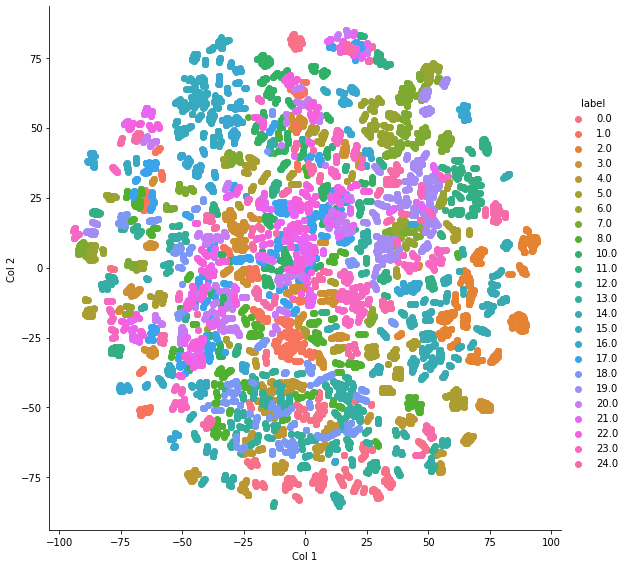

In [102]:
sns.FacetGrid(tsne_df, hue='label', height=8).map(plt.scatter, 'Col 1', 'Col 2').add_legend()

The separation of related features is not too distinct from the above graph. According to the sci-kit learn manual: "*It is highly recommended to use another dimensionality reduction method (e.g. PCA) to reduce the number of dimensions to a reasonable amount if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.*"

So, next we try the combination of PCA and t-SNE.

### PCA + t-SNE

In [103]:
from sklearn.decomposition import PCA
only_pca_model = PCA()
only_pca_model.n_components = 200
only_pca_data = only_pca_model.fit_transform(X_train/255)
only_pca_data = np.vstack((only_pca_data.T, y_train)).T

pca_tsne_model = TSNE(n_components =2, random_state =0, perplexity = 50, n_iter=1000, verbose=1)
pca_tsne_data = model.fit_transform(only_pca_data)

pca_tsne_data = np.vstack((pca_tsne_data.T, y_train)).T
pca_tsne_df = pd.DataFrame(pca_tsne_data, columns = ('Col 1', 'Col 2', 'label'))
pca_tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20591 samples in 0.004s...
[t-SNE] Computed neighbors for 20591 samples in 8.957s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20591
[t-SNE] Computed conditional probabilities for sample 2000 / 20591
[t-SNE] Computed conditional probabilities for sample 3000 / 20591
[t-SNE] Computed conditional probabilities for sample 4000 / 20591
[t-SNE] Computed conditional probabilities for sample 5000 / 20591
[t-SNE] Computed conditional probabilities for sample 6000 / 20591
[t-SNE] Computed conditional probabilities for sample 7000 / 20591
[t-SNE] Computed conditional probabilities for sample 8000 / 20591
[t-SNE] Computed conditional probabilities for sample 9000 / 20591
[t-SNE] Computed conditional probabilities for sample 10000 / 20591
[t-SNE] Computed conditional probabilities for sample 11000 / 20591
[t-SNE] Computed conditional probabilities for sample 12000 / 20591
[t-SNE] Computed conditional probabilities for sa

Col 1      Col 2  label
0 -55.200424 -48.439777   21.0
1  16.094810 -55.465763   17.0
2 -31.957006 -76.298592   15.0
3  14.993001  76.583374   13.0
4 -56.961411 -17.814453    4.0

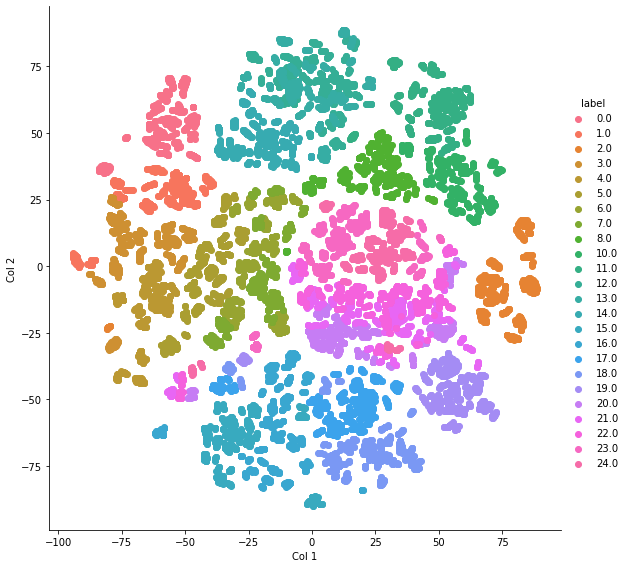

In [104]:
sns.FacetGrid(pca_tsne_df, hue='label', height=8).map(plt.scatter, 'Col 1', 'Col 2').add_legend()

From the graph above we see that we indeed see some clustering in our data. However, this reduced data-set cannot be used as an input for ML learning algorithms. t-SNE is purely an unsupervised method for dimesionality reduction/visualization, so it does not really work with train/validation/test sets.

Thus we fall back on using only PCA for dimentionality reduction in our data. 

### PCA

The idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible. We have to standardise the data as a first step as PCA is sensitive to the variances of the initial variables. For example, a variable that ranges between 0 and 100 will dominate over a variable that ranges between 0 and 1. 

In [105]:
# Standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

We next see how many principal components are required to explain a maximal amount of variance, that is to say, the components that capture most information from the data. 

With  1 principal components, total explained variance is 31.32 %
With 10 principal components, total explained variance is 69.04 %
With 30 principal components, total explained variance is 83.73 %
With 50 principal components, total explained variance is 88.74 %
With 100 principal components, total explained variance is 94.22 %
With 200 principal components, total explained variance is 97.86 %


Text(0, 0.5, 'Total variance')

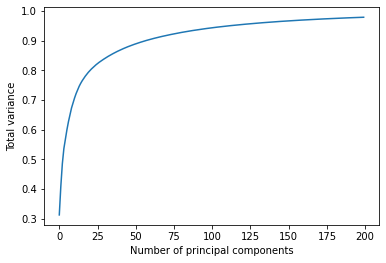

In [106]:
for k in [1, 10, 30, 50, 100, 200]:
    # perform PCA with given k components
    pca_model = PCA(k)
    pca_model.fit(X_train/255)
        
    #print cumulative explained variance ratio
    print('With %2d principal components, total explained variance is %4.2f %%' %(k, 100*pca_model.explained_variance_ratio_.cumsum()[k-1]))
    #plot the variance ratio wrt number of principal components
plt.plot(pca_model.explained_variance_ratio_.cumsum())
plt.xlabel('Number of principal components')
plt.ylabel('Total variance')

We will use 200 components as this explains 98% percent variance in our data. 

In [107]:
NCOMPONENTS = 200

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(X_train/255)
X_pca_val = pca.transform(X_val/255)
X_pca_test = pca.transform(X_test/255)
pca_std = np.std(X_pca_train)

print(X_train.shape)
print(X_pca_train.shape)

(20591, 784)
(20591, 200)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [108]:
X_pca_train.shape, X_pca_val.shape

((20591, 200), (6864, 200))

# Linear Classifier

We will apply SVM, Support Vector Machines which function on multiple hyperplanes that separate linearly separable data. The SVM algorithm calculates the optimally separating hyperplanes using concepts of geometry.

We choose the following hyperparameters in SVM in accordance with what has been used for the MNIST dataset in literature. Our algorithm performs fair (with 75 % accuracy) with the training and validation data (as expected) and scores 62% accuracy on the test set. 

### SVM

In [30]:
svc = SVC(kernel='rbf',C = 1, gamma = 0.001) 
# fit classifier to training set
svc.fit(X_pca_train,y_train)

# make predictions on validation set
y_pred=svc.predict(X_pca_val)

# compute and print accuracy score
print('Model accuracy score with rbf kernel, gamma = 0.001 and C = 1: {0:0.4f} on validation set'. format(accuracy_score(y_val, y_pred)))

Model accuracy score with rbf kernel, gamma = 0.001 and C = 1: 0.7481 on validation set


In [31]:
test_preds = svc.predict(X_pca_test)
acc_test = accuracy_score(test_preds, y_test)
print('Model accuracy score with rbf kernel, gamma = 0.001 and C = 1: {0:0.4f} on test set'. format(acc_test))

Model accuracy score with rbf kernel, gamma = 0.001 and C = 1: 0.6286 on test set


### Logistic Regression

In [109]:
LR_model = LogisticRegression(solver = 'liblinear', random_state = 0)
LR_model.fit(X_pca_train, y_train)

train_preds_baseline = LR_model.predict(X_pca_train)
val_preds_baseline = LR_model.predict(X_pca_val)
test_preds = LR_model.predict(X_pca_test)

acc_test = accuracy_score(test_preds, y_test)

print(f'Model accuracy score with Logistic Regression classifier: {acc_test}')

Model accuracy score with Logistic Regression classifier: 0.6529559397657557


# CNN classifier

Next we use a Sequential CNN model where layers of the neural network are stacked one after another. The hyper-parameters are again in accordance with previous work done using this dataset. 

Our model performs great on the validation set with 94% accuracy, but yield only a 38% accuracy when put on the test set. 

In [32]:
from keras.layers import *
model = Sequential()
layers = 1
units = 128

model.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
model.add(Dense(2, activation="relu"))
model.add(Dense(3, activation="relu"))
model.add(GaussianNoise(pca_std))
model.add(Dense(3, activation="relu"))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.1))
model.add(Dense(25, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()
history = model.fit(X_pca_train, Y_train, epochs=200, batch_size=256, validation_data = (X_pca_val, Y_val), verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 dense_2 (Dense)             (None, 3)                 9         
                                                                 
 gaussian_noise (GaussianNoi  (None, 3)                0         
 se)                                                             
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 128)               512       
                                                        

In [33]:
def plot_model_performance(metric, validations_metric):
    plt.plot(history.history[metric],label = str('Training ' + metric))
    plt.plot(history.history[validations_metric],label = str('Validation ' + metric))
    plt.legend()
    plt.savefig(str(metric + '_plot.png'))

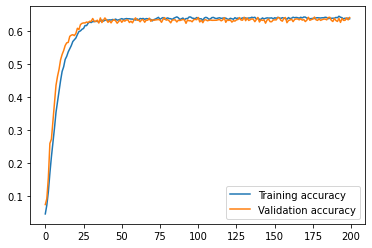

In [34]:
# plotting validation data set accuracy 
plot_model_performance('accuracy', 'val_accuracy')

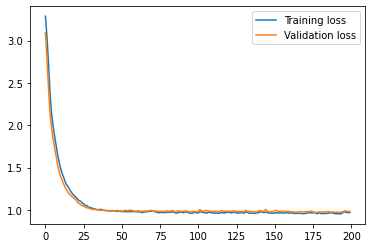

In [35]:
#plotting validation data set loss
plot_model_performance('loss', 'val_loss')

In [36]:
# test set
predictions = model.predict(X_pca_test, verbose=2)


225/225 - 0s - 339ms/epoch - 2ms/step


In [37]:
# test set accuracy
model.evaluate(X_pca_test, Y_test)

225/225 [==============================] - 0s 2ms/step - loss: 12.8565 - accuracy: 0.3015


[12.856508255004883, 0.30145007371902466]

# Hog feature detection

HOG, or Histogram of Oriented Gradients, is a feature descriptor which we will next use to extract features from our image data. The HOG feature descriptor counts the occurrences of gradient orientation in localized portions of an image.

In [3]:
# Load data
train = pd.read_csv("gdrive/MyDrive/w281/sign_mnist_train/sign_mnist_train.csv")
test = pd.read_csv("gdrive/MyDrive/w281/sign_mnist_test/sign_mnist_test.csv")
print("train data shape:",train.shape)
print("test data shape:",test.shape)


train data shape: (27455, 785)
test data shape: (7172, 785)


In [4]:
train_labels = np.array(train['label'].values)
test_labels  = np.array(test['label'].values)

In [5]:
train.drop('label', axis = 1, inplace = True)
test.drop('label', axis = 1, inplace = True)

In [6]:
train_images = train.values
train_images = np.array([np.reshape(i, (28, 28)) for i in train_images])
train_images = np.array([i.flatten() for i in train_images])

test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])

In [7]:
train_images_1 = train_images.reshape(27455,28,28,1)/255.0
test_images_1  = test_images.reshape(7172,28,28,1)/255.0

In [10]:
#method to plot extracted fetures
def pyramid_4xup_img(images):
    num = images.shape[0]
    dim = images.shape[1]
    img_4x = np.zeros((num,dim*4,dim*4,1))
    for i in range(num):
        img_4x[i,:,:,0] = cv2.pyrUp(cv2.pyrUp(images[i,:,:,0]))
    print(img_4x.shape)
    return(img_4x)

In [11]:
train_images_4 = pyramid_4xup_img(train_images_1)
test_images_4 = pyramid_4xup_img(test_images_1)

(27455, 112, 112, 1)
(7172, 112, 112, 1)


### 28x28 image with 2x2 Hog feature  
The original data images (28x28 pixel) were too small to extract meaningful feature. 

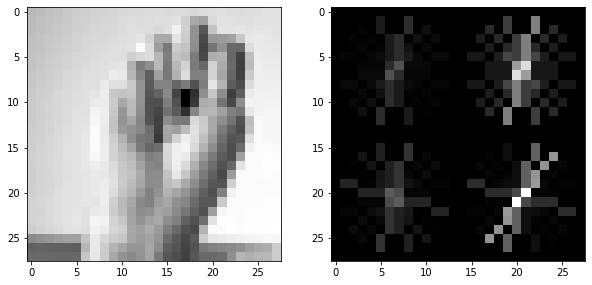

In [37]:
plt.figure(figsize = (10, 20))
ax = plt.subplot(1, 2, 1)
ax.imshow(train_images_1[4,:,:,0], cmap = 'gray')
fd_ex, hog_image_ex = hog(train_images_1[4,:,:,0], orientations=8, pixels_per_cell=(14,14), cells_per_block=(1, 1), visualize=True, multichannel=False)
hog_image_rescaled_ex = exposure.rescale_intensity(hog_image_ex, in_range=(0, 1))
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(hog_image_rescaled_ex, cmap = 'gray')

### 108x108 image with 8x8 Hog feature  
The images were resized to 4 times bigger in x,y direction which made possible to extract more features.

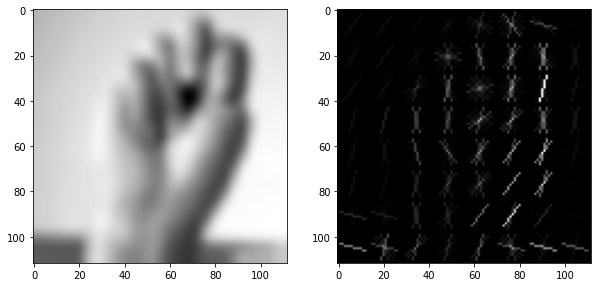

In [38]:
plt.figure(figsize = (10, 20))
ax = plt.subplot(1, 2, 1)
ax.imshow(train_images_4[4,:,:,0], cmap = 'gray')
fd_ex, hog_image_ex = hog(train_images_4[4,:,:,0], orientations=8, pixels_per_cell=(14,14), cells_per_block=(1, 1), visualize=True, multichannel=False)
hog_image_rescaled_ex = exposure.rescale_intensity(hog_image_ex, in_range=(0, 1))
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(hog_image_rescaled_ex, cmap = 'gray')

In [39]:
def plot_hogimg(num_examples, images, labels):

    # Creating the plot with colormap and size
    scale = 5
    #plt.rc('image', cmap='Greys')
    #plt.rc('figure', figsize=[num_examples*scale,10*scale])

    # Creating list indices of data with labels 0 through 9
    gridsize = 25
    gridsq = gridsize * num_examples #varying size by input of 'num_examples'
    indexdata = np.empty(gridsq)
    
    for i in np.unique(train_labels):
        #print(gridsize)
        count = 0
        while(count < num_examples):
            r = np.random.randint(0, 27454)
            if ((int(labels[r])) == i):
                #print(count,labels[r],r)
                indexdata[((i*num_examples)+count)]=r
                count=count+1

    plt.figure(figsize = (14, 35))
    plt.subplots_adjust(hspace=0.2, wspace=0.1)

    for i in range(0, gridsq):
      
        ax = plt.subplot(gridsize, num_examples, i+1)
        ax.axis('off')
        if int(indexdata[i])<= train_images_1.shape[0]:
          fd, hog_image = hog(images[int(indexdata[i]),:,:,0]/255, orientations=8, pixels_per_cell=(14, 14),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
          hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 1))
        
        ax.imshow(hog_image_rescaled, cmap='gray')
        
    
    plt.tight_layout()

Each row is the same label 10 images, but it is difficult to see patterns that are unique for each rows.

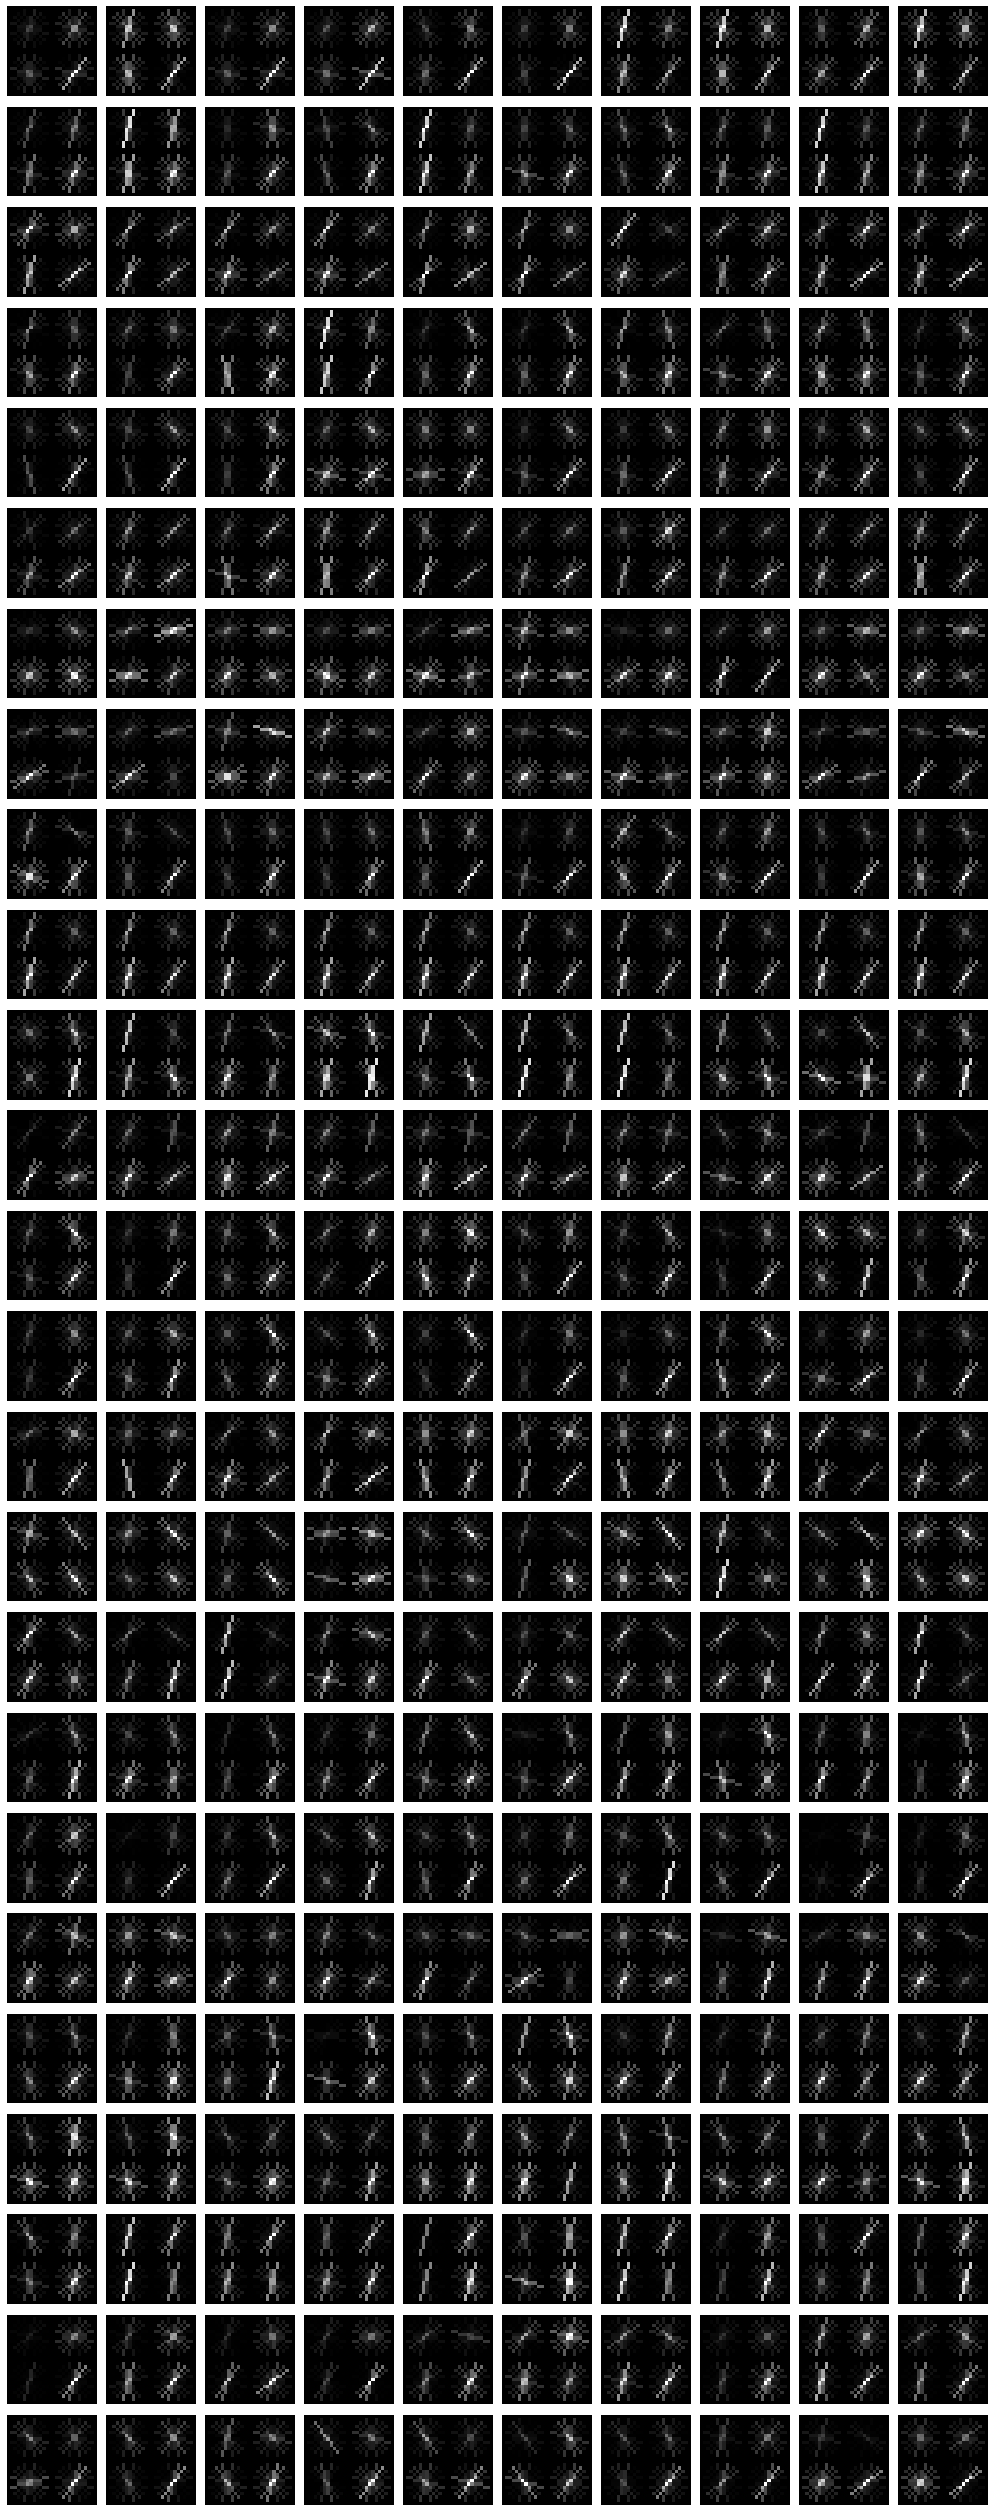

In [40]:
plot_hogimg(10, train_images_1, train_labels)

By increaseing the images size, we can see more structured patterns over the images in a same row.

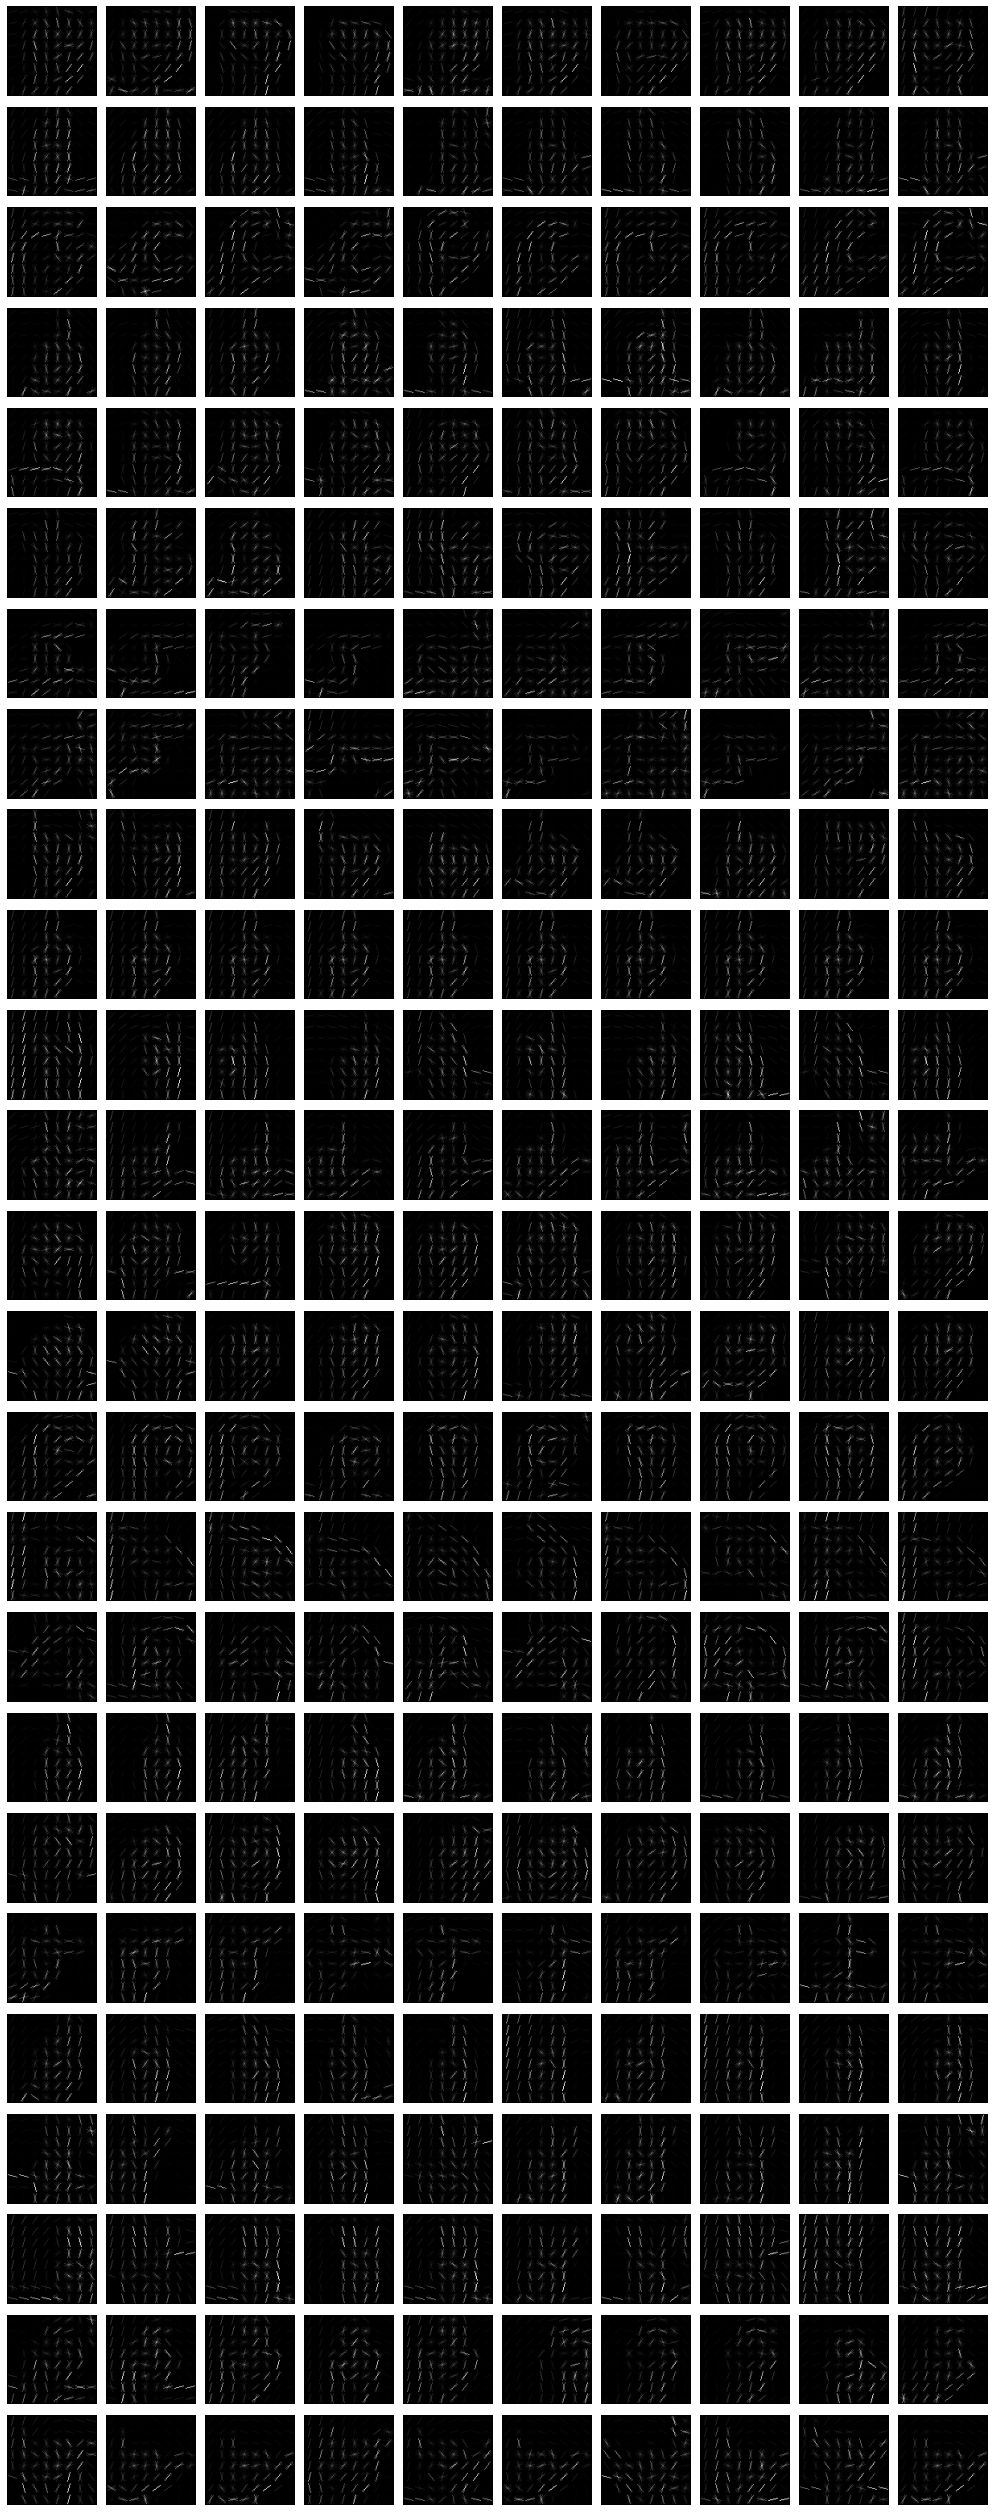

In [41]:
plot_hogimg(10, train_images_4, train_labels)

Extracting HOG features from train and test data set

In [8]:
def hog_feature(images):
    num = images.shape[0]
    dim = images.shape[1]

    hog_img = np.zeros(images.shape)
    out_feat = []
    for i in range(num):
        fd, hog_img = hog(images[i,:,:,0],
                                   orientations = 8, 
                                   pixels_per_cell = (14,14),
                                   cells_per_block=(1, 1), 
                                   visualize=True, 
                                   multichannel=False)
        
        out_feat.append(fd[np.newaxis, :])
    return np.vstack(out_feat)

In [12]:
hog_feat_train_1 = hog_feature(train_images_1)
hog_feat_test_1  = hog_feature(test_images_1)
hog_feat_train_4 = hog_feature(train_images_4)
hog_feat_test_4  = hog_feature(test_images_4)

In [13]:
display(hog_feat_train_1.shape)
display(hog_feat_train_4.shape)

(27455, 32)

(27455, 512)

### PCA with Hog features

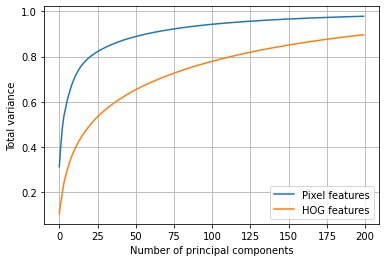

In [ ]:
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200]:
    # perform PCA with given k components
    pixel_model = PCA(k)
    hog_model = PCA(k)
    pixel_model.fit(train_images)
    hog_model.fit(hog_feat_train_4)
        
    
plt.plot(pixel_model.explained_variance_ratio_.cumsum())
plt.plot(hog_model.explained_variance_ratio_.cumsum())
plt.legend(['Pixel features','HOG features'])
plt.xlabel('Number of principal components')
plt.ylabel('Total variance')
plt.grid('on')

### PCA + t-SNE on hog features

In [ ]:
hog_pca_model = PCA(n_components = 200)

hog_pca_data = hog_pca_model.fit_transform(hog_feat_train_4)
hog_pca_data = np.vstack((hog_pca_data.T, train_labels)).T

hog_pca_tsne_model = TSNE(n_components = 2, random_state = 0, perplexity = 50, n_iter = 1000, verbose = 1)
hog_pca_tsne_data = hog_pca_tsne_model.fit_transform(hog_pca_data)

hog_pca_tsne_data = np.vstack((hog_pca_tsne_data.T, train_labels)).T
hog_pca_tsne_df = pd.DataFrame(hog_pca_tsne_data, columns = ('Col 1', 'Col 2', 'label'))
hog_pca_tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 27455 samples in 0.004s...
[t-SNE] Computed neighbors for 27455 samples in 25.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27455
[t-SNE] Computed conditional probabilities for sample 2000 / 27455
[t-SNE] Computed conditional probabilities for sample 3000 / 27455
[t-SNE] Computed conditional probabilities for sample 4000 / 27455
[t-SNE] Computed conditional probabilities for sample 5000 / 27455
[t-SNE] Computed conditional probabilities for sample 6000 / 27455
[t-SNE] Computed conditional probabilities for sample 7000 / 27455
[t-SNE] Computed conditional probabilities for sample 8000 / 27455
[t-SNE] Computed conditional probabilities for sample 9000 / 27455
[t-SNE] Computed conditional probabilities for sample 10000 / 27455
[t-SNE] Computed conditional probabilities for sample 11000 / 27455
[t-SNE] Computed conditional probabilities for sample 12000 / 27455
[t-SNE] Computed conditional probabilities for s

Col 1      Col 2  label
0  25.527929  60.860592    3.0
1  -7.290524  45.992496    6.0
2  62.713303  46.771809    2.0
3 -53.344059  15.422116    2.0
4 -30.474596  12.552487   13.0

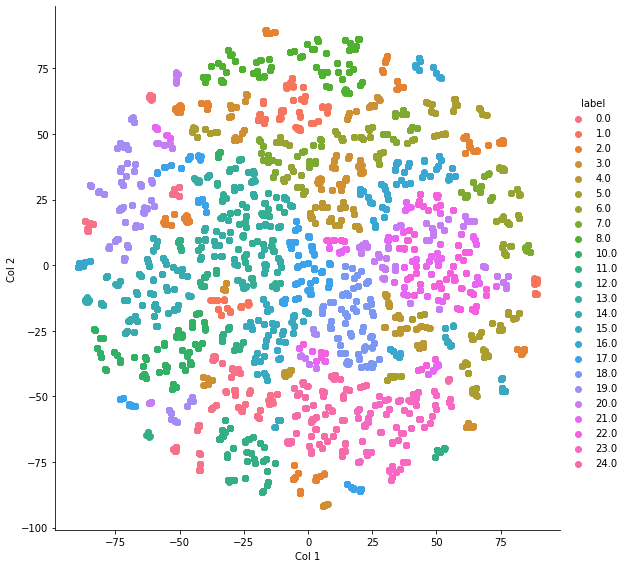

In [ ]:
sns.FacetGrid(hog_pca_tsne_df, hue='label', height=8).map(plt.scatter, 'Col 1', 'Col 2').add_legend()

There are some noticeable clusters from this plot. 

# FFT feature detection

We next use the FFT feature detection algorithm, that represents the image in both real and imaginary components.

By analyzing these values, we can detect blurring, edge detection, thresholding and texture analysis.



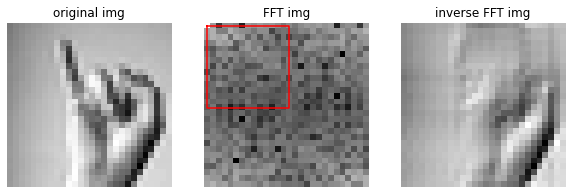

In [38]:
plt.rc('image',cmap = 'gray')
plt.figure(figsize = (10,30))

rdm_num = np.random.randint(train_images_1.shape[0])
example_img = train_images_1[rdm_num,:,:,0]

plt.subplot(1,3,1)
ax = plt.gca()
ax.set_title('original img')
ax.axis('off')
plt.imshow(example_img)

example_fft = fftpack.fft2(example_img)

plt.subplot(1,3,2)
ax = plt.gca()
ax.set_title('FFT img')
ax.axis('off')
plt.imshow(np.log(np.abs(example_fft.real)))
plt.plot([0,14,14,0,0], [0,0,14,14,0], color = 'red')

example_fft[14:,:] = 0
example_fft[:,14:] = 0

example_ifft = np.fft.ifft2(example_fft)
plt.subplot(1,3,3)
ax = plt.gca()
ax.set_title('inverse FFT img')
ax.axis('off')
plt.imshow(example_ifft.real)

For FFT features, we first convert the images to the frequency domain. Then, features are extracted from sum of rows, columns, and diagonal.  
The followings are the 2 features we extracted:


*   quarter of FFT converted img
*   sum of rows, columns, and diagonal



In [39]:
def fft_feature(images):
  num = images.shape[0]
  dim = images.shape[1]

  fft_img = np.zeros((dim,dim))
  fft_feat = np.zeros(2*dim+1)

  out_img = []
  out_feat = []
  for i in range(num):
    # converting images to frequency domain
    fft_img = fftpack.fft2(images[i,:,:,0]).real

    # extracting features from sum of rows, columns, and diagonal
    rowsum = np.abs(fft_img).sum(axis = 0)
    colsum = np.abs(fft_img).sum(axis = 1)
    diagsum = np.array([np.trace(np.abs(fft_img))])

    out_img.append(fft_img[:dim//2,:dim//2].flatten()[np.newaxis, :])
    out_feat.append(np.concatenate((rowsum, colsum, diagsum))[np.newaxis, :])
  return np.vstack(out_feat), np.vstack(out_img)

In [41]:
fft_feat_train, fft_img_train = fft_feature(train_images_1)
fft_feat_test,  fft_img_test  = fft_feature(test_images_1)

In [43]:
fft_feat_train.shape, fft_img_train.shape

((27455, 57), (27455, 196))

## PCA with FFT features

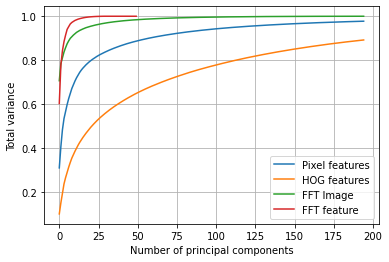

In [46]:
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 195]:
    # perform PCA with given k components
    pixel_model = PCA(k)
    hog_model = PCA(k)
    fft_img_model = PCA(k)
    pixel_model.fit(train_images)
    hog_model.fit(hog_feat_train_4)
    fft_img_model.fit(fft_img_train)
    if k<57:
      fft_model = PCA(k)
      fft_model.fit(fft_feat_train)    
    
plt.plot(pixel_model.explained_variance_ratio_.cumsum())
plt.plot(hog_model.explained_variance_ratio_.cumsum())
plt.plot(fft_img_model.explained_variance_ratio_.cumsum())
plt.plot(fft_model.explained_variance_ratio_.cumsum())
plt.legend(['Pixel features','HOG features','FFT Image','FFT feature'])
plt.xlabel('Number of principal components')
plt.ylabel('Total variance')
plt.grid('on')

### PCA + t-SNE on FFT features

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 27455 samples in 0.002s...
[t-SNE] Computed neighbors for 27455 samples in 15.486s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27455
[t-SNE] Computed conditional probabilities for sample 2000 / 27455
[t-SNE] Computed conditional probabilities for sample 3000 / 27455
[t-SNE] Computed conditional probabilities for sample 4000 / 27455
[t-SNE] Computed conditional probabilities for sample 5000 / 27455
[t-SNE] Computed conditional probabilities for sample 6000 / 27455
[t-SNE] Computed conditional probabilities for sample 7000 / 27455
[t-SNE] Computed conditional probabilities for sample 8000 / 27455
[t-SNE] Computed conditional probabilities for sample 9000 / 27455
[t-SNE] Computed conditional probabilities for sample 10000 / 27455
[t-SNE] Computed conditional probabilities for sample 11000 / 27455
[t-SNE] Computed conditional probabilities for sample 12000 / 27455
[t-SNE] Computed conditional probabilities for s

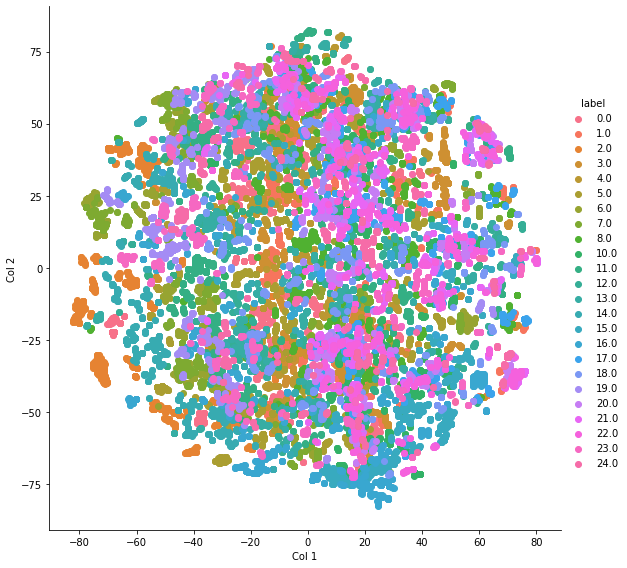

In [ ]:
fft_pca_model = PCA(n_components = 50)
fft_pca_data = fft_pca_model.fit_transform(fft_feat_train)
fft_pca_data = np.vstack((fft_pca_data.T, train_labels)).T

fft_pca_tsne_model = TSNE(n_components = 2, random_state = 0, perplexity = 50, n_iter = 1000, verbose = 1)
fft_pca_tsne_data = fft_pca_tsne_model.fit_transform(fft_pca_data)

fft_pca_tsne_data = np.vstack((fft_pca_tsne_data.T, train_labels)).T
fft_pca_tsne_df = pd.DataFrame(fft_pca_tsne_data, columns = ('Col 1', 'Col 2', 'label'))
fft_pca_tsne_df.head()


sns.FacetGrid(fft_pca_tsne_df, hue='label', height=8).map(plt.scatter, 'Col 1', 'Col 2').add_legend()


The FFT t-SNE + PCA does not yield many detectable clusters in our data. 

# Classifiers: Hog and FFT features

### Splitting the data into training and validation sets

#### Hog feature

In [124]:
#hog features
X_train, X_val, y_train, y_val = train_test_split(hog_feat_train_4, train_labels, test_size=0.2, random_state=1)
X_train.shape

(21964, 512)

##### SVM

In [128]:
#linear classifier for hog features
from sklearn import svm
clf = svm.SVC(kernel = 'rbf', C = 1, gamma=0.001) # C sets regularization
clf.fit(X_train, y_train)

SVC(C=1, gamma=0.001)

In [129]:
# test data accuracy for for hog features
train_preds_baseline = clf.predict(X_train)
val_preds_baseline = clf.predict(X_val)
test_preds = clf.predict(hog_feat_test_4)
acc_baseline_train = accuracy_score(train_preds_baseline, y_train)
acc_baseline_val = accuracy_score(val_preds_baseline, y_val)
acc_test = accuracy_score(test_preds, test_labels)
print(f'Training accuracy for our baseline (using hog features): {acc_baseline_train}')
print(f'Validation accuracy for our baseline (using hog features): {acc_baseline_val}')
print(f'Test accuracy for our baseline (using hog features): {acc_test}')

Training accuracy for our baseline (using hog features): 0.9713622291021672
Validation accuracy for our baseline (using hog features): 0.9686760152977599
Test accuracy for our baseline (using hog features): 0.8750697155605132


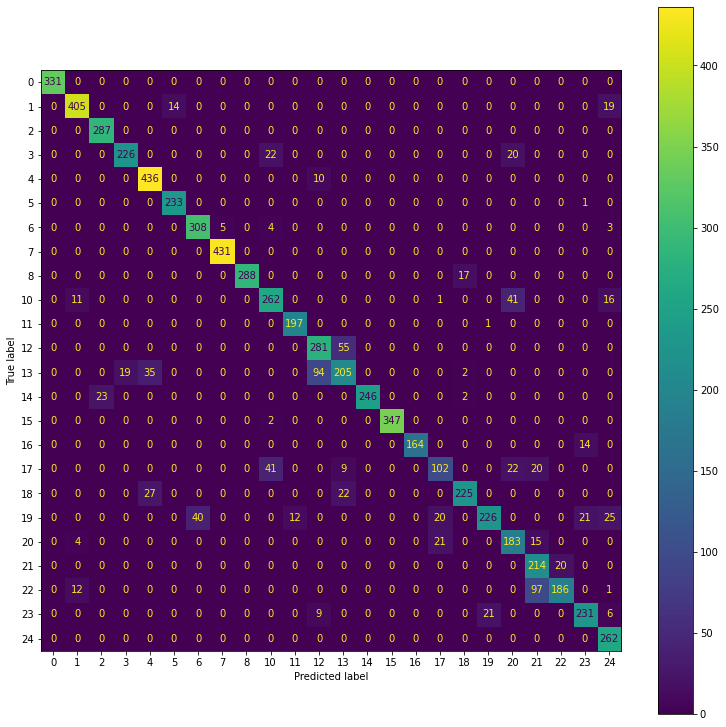

In [130]:
confusion_matrix = metrics.confusion_matrix(test_preds, test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

f,ax = plt.subplots(1,1,figsize=(13,13))

#cm_display.plot()
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, test_labels, ax=ax)
#plt.figure(figsize=(15,15))
plt.show()


The HOG features already show a better value of test set accuracy to 87.5%. We next see, if we can reproduce this accuracy value on the CNN model. We use the same Sequential model as we used in the case of pixel features.  

##### Logistic Regression

In [65]:
LR_model = LogisticRegression(solver = 'liblinear', random_state = 0)
LR_model.fit(X_train, y_train)

train_preds_baseline = LR_model.predict(X_train)
val_preds_baseline = LR_model.predict(X_val)
test_preds = LR_model.predict(hog_feat_test_4)
acc_baseline_train = accuracy_score(train_preds_baseline, y_train)
acc_baseline_val = accuracy_score(val_preds_baseline, y_val)
acc_test = accuracy_score(test_preds, test_labels)
print(f'Training accuracy for our baseline (using hog features): {acc_baseline_train}')
print(f'Validation accuracy for our baseline (using hog features): {acc_baseline_val}')
print(f'Test accuracy for our baseline (using hog features): {acc_test}')


Training accuracy for our baseline (using hog features): 1.0
Validation accuracy for our baseline (using hog features): 0.9998178838098707
Test accuracy for our baseline (using hog features): 0.9138315672058004


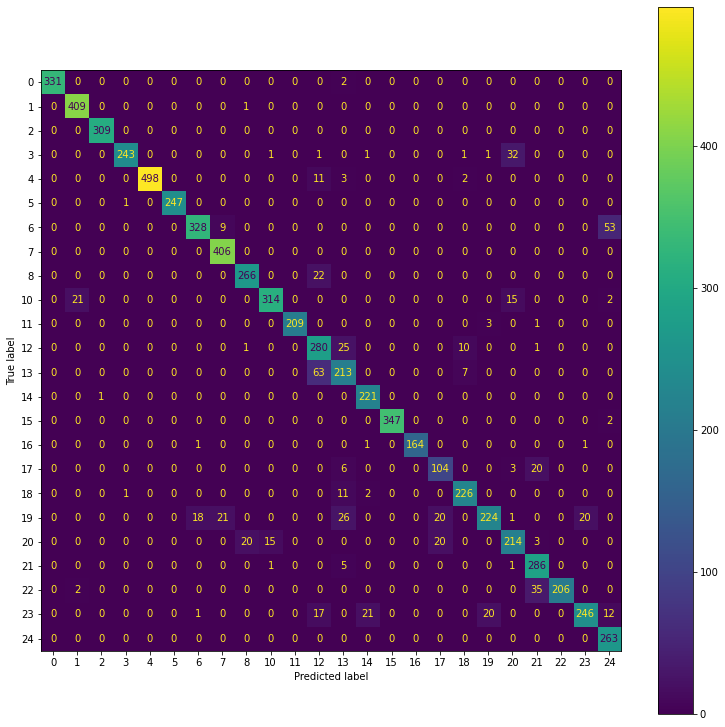

In [66]:
confusion_matrix = metrics.confusion_matrix(test_preds, test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

f,ax = plt.subplots(1,1,figsize=(13,13))

#cm_display.plot()
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, test_labels, ax=ax)
#plt.figure(figsize=(15,15))
plt.show()


##### CNN

In [91]:
from keras.layers import Activation, Dense, GaussianNoise, Dropout
from keras.utils import np_utils
X_train_hog, X_val_hog, y_train_hog, y_val_hog = train_test_split(hog_feat_train_4, train_labels, test_size=0.2, random_state=1)
#X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(train_images_1.reshape(27455,784), train_label_he, test_size=0.2, random_state=1)

#y_train = y_train_CNN.values.astype('int32')
Y_train = np_utils.to_categorical(y_train_hog.astype('int32'))

#y_val = y_val_CNN.values.astype('int32')
Y_val = np_utils.to_categorical(y_val_hog)


hog_model_CNN = Sequential()
layers = 1
units = 128
NCOMPONENTS = X_train_hog.shape[1]
X_std = np.std(X_train_hog)

hog_model_CNN.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
hog_model_CNN.add(Dense(2, activation="relu"))
hog_model_CNN.add(GaussianNoise(X_std))
#hog_model_CNN.add(Dense(3, activation="relu"))
for i in range(layers):
    hog_model_CNN.add(Dense(units, activation='relu'))
    hog_model_CNN.add(GaussianNoise(X_std))
    hog_model_CNN.add(Dropout(0.1))
hog_model_CNN.add(Dense(25, activation='softmax'))

hog_model_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


hog_model_CNN.summary()
history = hog_model_CNN.fit(X_train_hog, Y_train, epochs=200, batch_size=256, validation_data = (X_val_hog, Y_val), verbose=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               65664     
                                                                 
 dense_19 (Dense)            (None, 2)                 258       
                                                                 
 gaussian_noise_8 (GaussianN  (None, 2)                0         
 oise)                                                           
                                                                 
 dense_20 (Dense)            (None, 128)               384       
                                                                 
 gaussian_noise_9 (GaussianN  (None, 128)              0         
 oise)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [92]:
# Hog feature CNN accuracy 63%
test_labels_cat = np_utils.to_categorical(test_labels)
result = hog_model_CNN.evaluate(hog_feat_test_4, test_labels_cat, batch_size = 256)
result
print("test loss, test acc:", result)

29/29 [==============================] - 0s 2ms/step - loss: 5.2037 - accuracy: 0.6631
test loss, test acc: [5.203747749328613, 0.6631343960762024]


#### FFT feature

##### SVM

In [67]:
# FFT features train-val spilt
X_train, X_val, y_train, y_val = train_test_split(fft_feat_train, train_labels, test_size=0.2, random_state=1)

In [68]:
clf = SVC(kernel = 'poly', C = 10, gamma=0.01) # C sets regularization
clf.fit(X_train, y_train)

SVC(C=1000, gamma=0.001)

In [69]:
train_preds_baseline = clf.predict(X_train)
val_preds_baseline = clf.predict(X_val)
test_preds = clf.predict(fft_feat_test)
acc_baseline_train = accuracy_score(train_preds_baseline, y_train)
acc_baseline_val = accuracy_score(val_preds_baseline, y_val)
acc_test = accuracy_score(test_preds, test_labels)
print(f'Training accuracy for our baseline (using FFT features): {acc_baseline_train}')
print(f'Validation accuracy for our baseline (using FFT features): {acc_baseline_val}')
print(f'Test accuracy for our baseline (using FFT features): {acc_test}')

Training accuracy for our baseline (using all FFT features): 1.0
Validation accuracy for our baseline (using all FFT features): 0.8246221089054817
Test accuracy for our baseline (using all FFT features): 0.3594534300055772


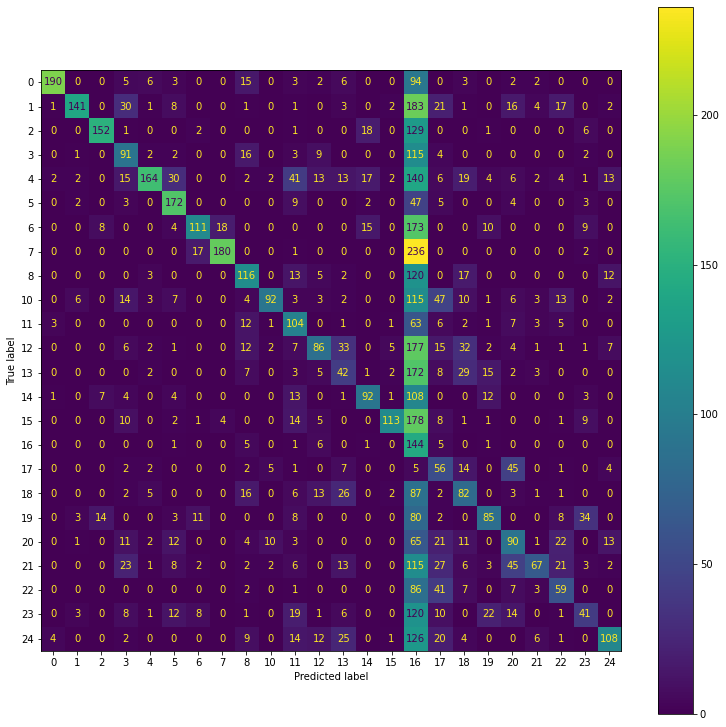

In [70]:
confusion_matrix = metrics.confusion_matrix(test_preds, test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

f,ax = plt.subplots(1,1,figsize=(13,13))

#cm_display.plot()
metrics.ConfusionMatrixDisplay.from_predictions( test_labels, test_preds, ax=ax)
#plt.figure(figsize=(15,15))
plt.show()


##### Logistic Regression

In [73]:
LR_model = LogisticRegression(solver = 'liblinear', random_state = 0)
LR_model.fit(X_train, y_train)

train_preds_baseline = LR_model.predict(X_train)
val_preds_baseline = LR_model.predict(X_val)
test_preds = LR_model.predict(fft_feat_test)
acc_baseline_train = accuracy_score(train_preds_baseline, y_train)
acc_baseline_val = accuracy_score(val_preds_baseline, y_val)
acc_test = accuracy_score(test_preds, test_labels)
print(f'Training accuracy for our baseline (using FFT features): {acc_baseline_train}')
print(f'Validation accuracy for our baseline (using FFT features): {acc_baseline_val}')
print(f'Test accuracy for our baseline (using FFT features): {acc_test}')

Training accuracy for our baseline (using hog features): 0.48319978146057185
Validation accuracy for our baseline (using hog features): 0.468402841012566
Test accuracy for our baseline (using hog features): 0.32069157836029


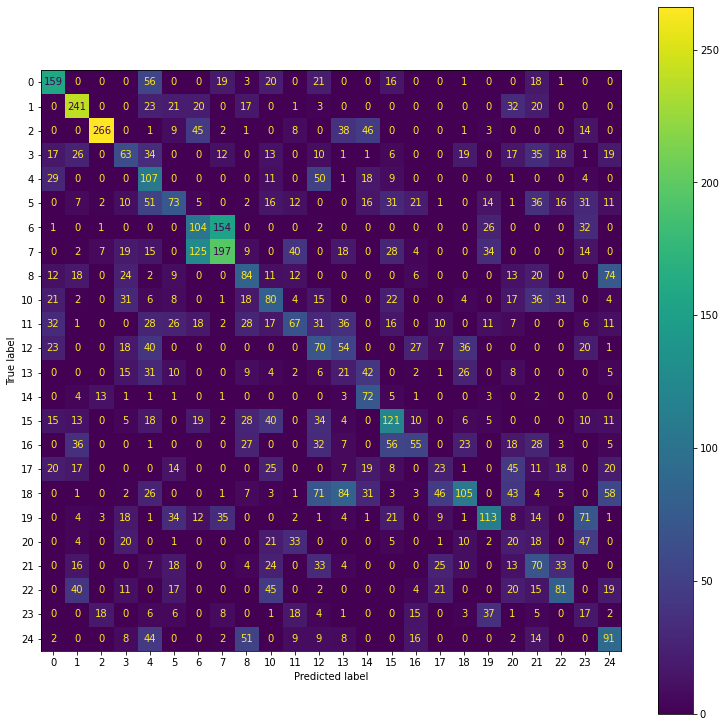

In [74]:
confusion_matrix = metrics.confusion_matrix(test_preds, test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

f,ax = plt.subplots(1,1,figsize=(13,13))

metrics.ConfusionMatrixDisplay.from_predictions(test_preds, test_labels, ax=ax)
#plt.figure(figsize=(15,15))
plt.show()

##### CNN

In [75]:
#FFT model CNN
X_train_FFT, X_val_FFT, y_train_FFT, y_val_FFT = train_test_split(fft_feat_train, train_labels, test_size=0.2, random_state=1)

#y_train = y_train_CNN.values.astype('int32')
Y_train = np_utils.to_categorical(y_train_FFT.astype('int32'))
#y_val = y_val_CNN.values.astype('int32')
Y_val = np_utils.to_categorical(y_val_FFT)

In [76]:
#FFT model CNN
X_train_FFT, X_val_FFT, y_train_FFT, y_val_FFT = train_test_split(fft_feat_train, train_labels, test_size=0.2, random_state=1)

Y_train = np_utils.to_categorical(y_train_FFT)
Y_val = np_utils.to_categorical(y_val_FFT)

FFT_model_CNN = Sequential()
layers = 1
units = 128
NCOMPONENTS = X_train_FFT.shape[1]
X_std = np.std(X_train_FFT)

FFT_model_CNN.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
FFT_model_CNN.add(Dense(2, activation="relu"))
FFT_model_CNN.add(GaussianNoise(X_std))
for i in range(layers):
    FFT_model_CNN.add(Dense(units, activation='relu'))
    FFT_model_CNN.add(GaussianNoise(X_std))
    FFT_model_CNN.add(Dropout(0.3))
FFT_model_CNN.add(Dense(25, activation='softmax'))

FFT_model_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


FFT_model_CNN.summary()
history = FFT_model_CNN.fit(X_train_FFT, Y_train, epochs=200, batch_size=256, validation_data = (X_val_FFT, Y_val), verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               7424      
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                                 
 gaussian_noise_4 (GaussianN  (None, 2)                0         
 oise)                                                           
                                                                 
 dense_12 (Dense)            (None, 128)               384       
                                                                 
 gaussian_noise_5 (GaussianN  (None, 128)              0         
 oise)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [52]:
# FFT feature CNN accuracy 24.0%
result = FFT_model_CNN.evaluate(fft_feat_test, test_labels_cat, batch_size = 256)
print("test loss, test acc:", result)

29/29 [==============================] - 0s 2ms/step - loss: 2.6983 - accuracy: 0.0884
test loss, test acc: [2.698347330093384, 0.08839932829141617]


#### FFT image

In [133]:
### FFT image
X_train, X_val, y_train, y_val = train_test_split(fft_img_train, train_labels, test_size=0.2, random_state=1)

##### SVM

In [119]:
clf = SVC(kernel = 'rbf', C = 1000, gamma=0.001) # C sets regularization
clf.fit(X_train, y_train)

train_preds_baseline = clf.predict(X_train)
val_preds_baseline = clf.predict(X_val)
test_preds = clf.predict(fft_img_test)
acc_baseline_train = accuracy_score(train_preds_baseline, y_train)
acc_baseline_val = accuracy_score(val_preds_baseline, y_val)
acc_test = accuracy_score(test_preds, test_labels)
print(f'Training accuracy for our baseline (using all FFT images): {acc_baseline_train}')
print(f'Validation accuracy for our baseline (using all FFT images): {acc_baseline_val}')
print(f'Test accuracy for our baseline (using all FFT images): {acc_test}')

Training accuracy for our baseline (using all FFT images): 1.0
Validation accuracy for our baseline (using all FFT images): 0.9918047714441813
Test accuracy for our baseline (using all FFT images): 0.7334076965978806


##### Logistic Regression

In [121]:
LR_model = LogisticRegression(solver = 'liblinear', random_state = 0)
LR_model.fit(X_train, y_train)

train_preds_baseline = LR_model.predict(X_train)
val_preds_baseline = LR_model.predict(X_val)
test_preds = LR_model.predict(fft_img_test)
acc_baseline_train = accuracy_score(train_preds_baseline, y_train)
acc_baseline_val = accuracy_score(val_preds_baseline, y_val)
acc_test = accuracy_score(test_preds, test_labels)
print(f'Training accuracy for our baseline (using FFT images): {acc_baseline_train}')
print(f'Validation accuracy for our baseline (using FFT images): {acc_baseline_val}')
print(f'Test accuracy for our baseline (using FFT images): {acc_test}')

Training accuracy for our baseline (using FFT images): 0.9570205791294846
Validation accuracy for our baseline (using FFT images): 0.952467674376252
Test accuracy for our baseline (using FFT images): 0.3569436698271054


##### CNN

In [143]:
#FFT model CNN
X_train_FFT, X_val_FFT, y_train_FFT, y_val_FFT = train_test_split(fft_img_train, train_labels, test_size=0.2, random_state=1)

Y_train = np_utils.to_categorical(y_train_FFT)
Y_val = np_utils.to_categorical(y_val_FFT)

FFT_model_CNN = Sequential()
layers = 1
units = 128
NCOMPONENTS = X_train_FFT.shape[1]
X_std = np.std(X_train_FFT)

FFT_model_CNN.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
FFT_model_CNN.add(Dense(2, activation="relu"))
FFT_model_CNN.add(GaussianNoise(X_std))
FFT_model_CNN.add(Dense(3, activation="relu"))
for i in range(layers):
    FFT_model_CNN.add(Dense(units, activation='relu'))
    FFT_model_CNN.add(GaussianNoise(X_std))
    FFT_model_CNN.add(Dropout(0.3))
FFT_model_CNN.add(Dense(25, activation='softmax'))

FFT_model_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



FFT_model_CNN.summary()
history = FFT_model_CNN.fit(X_train_FFT, Y_train, epochs=200, batch_size=256, validation_data = (X_val_FFT, Y_val), verbose=2)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               25216     
                                                                 
 dense_45 (Dense)            (None, 2)                 258       
                                                                 
 gaussian_noise_20 (Gaussian  (None, 2)                0         
 Noise)                                                          
                                                                 
 dense_46 (Dense)            (None, 128)               384       
                                                                 
 gaussian_noise_21 (Gaussian  (None, 128)              0         
 Noise)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 128)             

In [147]:
# FFT feature CNN accuracy 24.0%
result = FFT_model_CNN.evaluate(fft_img_test, test_labels_cat, batch_size = 256)
print("test loss, test acc:", result)

29/29 [==============================] - 0s 3ms/step - loss: 5.0640 - accuracy: 0.2443
test loss, test acc: [5.063971042633057, 0.24428331851959229]


# ResNet152 feature detection

The details of this procedure can be found in this notebook: 
[ResNet notebook](https://github.com/atreyid/w281-fp/blob/main/W281_fp_PE.ipynb)

# Conclusions:

We used the ASL data set to analyze hand gestures using different image processing algorithms. Our main aim was to maximize the accuracy on the test data set.

The comparison of test set accuracy is found in the table below. The trends are similar: All data performed better on a linear classifier than the non-linear one. The best accuracy is obtained using HOG feature extraction and the linear classifier. 

In [148]:
#@title
df_accuracy = pd.DataFrame({'Classifiers' : ['SVM', 'Logistic Regression', 'CNN'],
                            'Pixel': [62.9, 65.3, 34.5],
                            'HOG':[87.5, 91.4, 63.1] ,
                            'FFT feat':[35.9, 32.1, 8.8 ],
                            'FFT img':[73.3, 35.7, 24.4 ],
                            'ResNet152':[0.4, 0.5, 0.5]})

In [149]:
#@title
df_accuracy.set_index('Classifiers')

Pixel   HOG  FFT feat  FFT img  ResNet152
Classifiers                                                   
SVM                   62.9  87.5      35.9     73.3        0.4
Logistic Regression   65.3  91.4      32.1     35.7        0.5
CNN                   34.5  63.1       8.8     24.4        0.5